In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

## Loading the IMDB dataset

In [2]:
# load the IMDB dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

## Data Preparation

In [4]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

# vectorize the data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

# set aside a validation set
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## Modeling

### 1. Experiment with number of hidden layers

In [6]:
layer_experiments = [1, 2, 3]
layer_results = {}
for num_layers in layer_experiments:
    model = models.Sequential()
    for _ in range(num_layers):
        model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=20,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=0)

    val_acc = history.history['val_accuracy'][-1]
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    layer_results[num_layers] = {'val_acc': val_acc, 'test_acc': test_acc}

### 2. Experiment with number of hidden units

In [7]:
unit_experiments = [32, 64]
unit_results = {}
for num_units in unit_experiments:
    model = models.Sequential([
        layers.Dense(num_units, activation='relu'),
        layers.Dense(num_units, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=20,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=0)

    val_acc = history.history['val_accuracy'][-1]
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    unit_results[num_units] = {'val_acc': val_acc, 'test_acc': test_acc}

### 3. Experiment with mse loss function

In [8]:
model_mse = models.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_mse.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=['accuracy'])

history_mse = model_mse.fit(partial_x_train,
                            partial_y_train,
                            epochs=20,
                            batch_size=512,
                            validation_data=(x_val, y_val),
                            verbose=0)

val_acc_mse = history_mse.history['val_accuracy'][-1]
test_loss_mse, test_acc_mse = model_mse.evaluate(x_test, y_test, verbose=0)
mse_results = {'val_acc': val_acc_mse, 'test_acc': test_acc_mse}

### 4. Experiment with tanh activation

In [9]:
model_tanh = models.Sequential([
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1, activation='sigmoid')
])

model_tanh.compile(optimizer='rmsprop',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_tanh = model_tanh.fit(partial_x_train,
                              partial_y_train,
                              epochs=20,
                              batch_size=512,
                              validation_data=(x_val, y_val),
                              verbose=0)

val_acc_tanh = history_tanh.history['val_accuracy'][-1]
test_loss_tanh, test_acc_tanh = model_tanh.evaluate(x_test, y_test, verbose=0)
tanh_results = {'val_acc': val_acc_tanh, 'test_acc': test_acc_tanh}

### 5. Experiment with dropout for regularization

In [10]:
from tensorflow.keras.layers import Dropout

model_dropout = models.Sequential([
    layers.Dense(16, activation='relu'),
    Dropout(0.5),
    layers.Dense(16, activation='relu'),
    Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_dropout.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

history_dropout = model_dropout.fit(partial_x_train,
                                    partial_y_train,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(x_val, y_val),
                                    verbose=0)

val_acc_dropout = history_dropout.history['val_accuracy'][-1]
test_loss_dropout, test_acc_dropout = model_dropout.evaluate(x_test, y_test, verbose=0)
dropout_results = {'val_acc': val_acc_dropout, 'test_acc': test_acc_dropout}

In [12]:
results = {
    'Number of Layers': layer_results,
    'Number of Units': unit_results,
    'MSE Loss': mse_results,
    'Tanh Activation': tanh_results,
    'Dropout Regularization': dropout_results
}

result_table = []
for experiment, res in results.items():
    if isinstance(res, dict):
        for key, value in res.items():
            if isinstance(value, dict):
                result_table.append([experiment + f' ({key})', value['val_acc'], value['test_acc']])
            else:
                result_table.append([experiment, res['val_acc'], res['test_acc']])
                break

result_df = pd.DataFrame(result_table, columns=['Experiment', 'Validation Accuracy', 'Test Accuracy'])
result_df

,Experiment,Validation Accuracy,Test Accuracy
0,Number of Layers (1),0.8770,0.86764
1,Number of Layers (2),0.8672,0.85484
2,Number of Layers (3),0.8665,0.85328
3,Number of Units (32),0.8677,0.85468
4,Number of Units (64),0.8763,0.86468
5,MSE Loss,0.8738,0.86452
6,Tanh Activation,0.8678,0.85288
7,Dropout Regularization,0.8814,0.87364


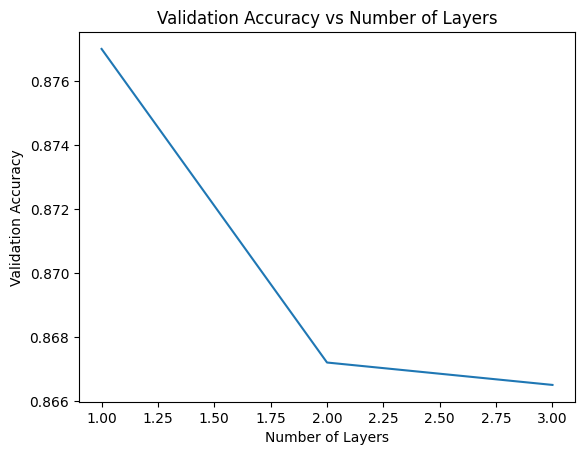

In [13]:
layer_vals = [layer_results[i]['val_acc'] for i in layer_experiments]
plt.figure()
plt.plot(layer_experiments, layer_vals)
plt.title('Validation Accuracy vs Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Validation Accuracy')
plt.show()